# MNIST best results
Result	Method	Venue	Details
1. 0.21%	Regularization of Neural Networks using DropConnect	ICML 2013	
2. 0.23%	Multi-column Deep Neural Networks for Image Classiﬁcation	CVPR 2012	
3. 0.23%	APAC: Augmented PAttern Classification with Neural Networks	arXiv 2015	
4. 0.24%	Batch-normalized Maxout Network in Network	arXiv 2015	Details
5. 0.29%	Generalizing Pooling Functions in Convolutional Neural Networks: Mixed, Gated, and Tree	AISTATS 2016	Details
6. 0.31%	Recurrent Convolutional Neural Network for Object Recognition	CVPR 2015	

http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

## Results of this model on MNIST test data: 
1. 0.22% test error rate with ensemble of 10 CNNs
2. 0.21% test error rate with ensemble of 6 selected CNNs
3. 0.26% test error rate for best single model

In [1]:
%matplotlib inline

In [2]:
import keras
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import Flatten, Lambda, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam as Adam

# try leaky relu
from keras.layers.advanced_activations import LeakyReLU

Using Theano backend.
Using cuDNN version 5005 on context None
Preallocating 7295/8105 Mb (0.900000) on cuda
Mapped name None to device cuda: GeForce GTX 1070 (0000:28:00.0)


# Load MNIST dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# store labels on test set for visualization
test_labels = y_test

In [4]:
rows = 28
cols = 28

# theano input shape
input_shape = (1, rows, cols)

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
# vgg expects channels - here we have just one
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)
x_train.shape

(60000, 1, 28, 28)

In [7]:
# convert to float
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# normalize
x_train /= 255
x_test /= 255

In [8]:
y_train.shape

(60000,)

In [9]:
# labels should be onehot encoded
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

y_train.shape

(60000, 10)

In [10]:
y_train[:5]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

# Define model

In [11]:
# calculate mean and standard deviation
mean_px = x_train.mean().astype(np.float32)
std_px = x_train.std().astype(np.float32)

In [12]:
# function to normalize input data
def norm_input(x): return (x-mean_px)/std_px

In [13]:
# Batchnorm + dropout + data augmentation
def create_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28), output_shape=(1,28,28)),
        Conv2D(32, (3,3)),
        LeakyReLU(),
        BatchNormalization(axis=1),
        Conv2D(32, (3,3)),
        LeakyReLU(),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Conv2D(64, (3,3)),
        LeakyReLU(),
        BatchNormalization(axis=1),
        Conv2D(64, (3,3)),
        LeakyReLU(),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512),
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Data augmentation
Use keras's data augmentation.

In [14]:
batch_size = 512

In [15]:
from keras.preprocessing.image import ImageDataGenerator

In [16]:
gen = ImageDataGenerator(rotation_range=12, width_shift_range=0.1, shear_range=0.3,
                        height_shift_range=0.1, zoom_range=0.1, data_format='channels_first')
batches = gen.flow(x_train, y_train, batch_size=batch_size)
test_batches = gen.flow(x_test, y_test, batch_size=batch_size)
steps_per_epoch = int(np.ceil(batches.n/batch_size))
validation_steps = int(np.ceil(test_batches.n/batch_size))

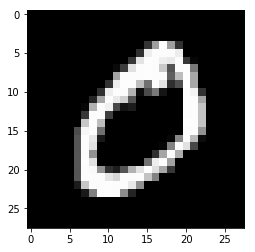

In [17]:
import matplotlib.pyplot as plt

# load ONE image from training set to display on screen
img = x_train[1]

# visualize original image
plt.imshow(img[0], cmap='gray')

In [18]:
# trick our generator into believing img has enough dimensions
# and get some augmented images for our single test image
img = np.expand_dims(img, axis=0)
aug_iter = gen.flow(img)

In [19]:
aug_img = next(aug_iter)[0].astype(np.float32)
aug_img.shape

(1, 28, 28)

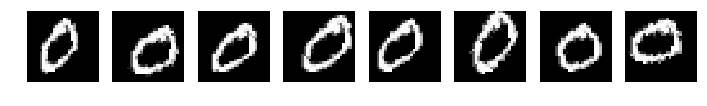

In [20]:
import matplotlib.pyplot as plt

# show augmented images
f = plt.figure(figsize=(12,6))
for i in range(8):
    sp = f.add_subplot(2, 26//3, i+1)
    sp.axis('Off')
    aug_img = next(aug_iter)[0].astype(np.float32)
    plt.imshow(aug_img[0], cmap='gray')

# Create models with saved weights

In [21]:
models = []

for i in range(10):
    m = create_model()
    m.load_weights("weights/weights_leaky_relu_model_0.22_"+str(i)+'.pkl')
    models.append(m)

# Ensembling
Here we create ten models and fit them to our augmented data. We use the mean prediction from all ten classifiers as our final prediction. This should average out errors in our classifiers and enable us to predict with higher accuracy.

In [21]:
# fit the model on batches with real-time data augmentation
def fit_model(m):
    m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=1, verbose=0,
                   validation_data=test_batches, validation_steps=validation_steps)
    m.optimizer.lr = 0.1
    m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=4, verbose=0,
                   validation_data=test_batches, validation_steps=validation_steps)
    m.optimizer.lr = 0.01
    m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=12, verbose=0,
                   validation_data=test_batches, validation_steps=validation_steps)
    m.optimizer.lr = 0.001
    m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=18, verbose=0,
                   validation_data=test_batches, validation_steps=validation_steps)
    return m

## Create and train ten models

In [ ]:
models = []

for i in range(10):
    print("Training model {}".format(i))
    m = fit_model(create_model())
    models.append(m)

In [ ]:
# train models some more if accuracy is not satisfying enough
for i, m in enumerate(models):
    m.optimizer.lr = 0.0001
    print("Model {}".format(i))
    m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=2,
                   validation_data=test_batches, validation_steps=validation_steps)

# Evaluate Model

In [23]:
eval_batch_size = 512

In [24]:
# evaluate every model
evals = np.array([m.evaluate(x_test,y_test, batch_size=eval_batch_size) for m in models])

 9728/10000 [============================>.] - ETA: 0s

In [25]:
# calculate mean from evaluations
evals.mean(axis=0)

array([ 0.01117256,  0.99643   ])

In [26]:
all_preds = np.stack([m.predict(x_test, batch_size=eval_batch_size) for m in models])

In [27]:
all_preds.shape

(10, 10000, 10)

In [28]:
avg_preds = all_preds.mean(axis=0)
avg_preds.shape

(10000, 10)

In [29]:
# display error rate in percent
(1 - keras.metrics.categorical_accuracy(y_test, avg_preds).eval().mean()) * 100

0.2200007438659668

# Show test error rate of every model separately

Results for .22 average error rate model weights (Model # / error rate)
1. 0.370001792908
2. 0.330001115799
3. 0.429999828339
4. 0.349998474121
5. 0.370001792908
6. 0.340002775192
7. 0.370001792908
8. 0.360000133514
9. 0.29000043869
10. 0.360000133514

In [30]:
for i, m in enumerate(models):
    pred = np.array(m.predict(x_test, batch_size=eval_batch_size))
    print(i+1, (1 - keras.metrics.categorical_accuracy(y_test, pred).eval().mean()) * 100)

1 0.370001792908
2 0.330001115799
3 0.429999828339
4 0.349998474121
5 0.370001792908
6 0.340002775192
7 0.370001792908
8 0.360000133514
9 0.29000043869
10 0.360000133514


In [117]:
# calculate accuracy of a single model
pred = np.array(models[i].predict(x_test, batch_size=eval_batch_size))
print(i, (1 - keras.metrics.categorical_accuracy(y_test, pred).eval().mean()) * 100)

8 0.29000043869


# Plot Training History

Here we create and train a single model from scratch and create a plot of the training history.

In [41]:
# create and train a single model
m = create_model()
history = m.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=10, verbose=0,
                         validation_data=test_batches, validation_steps=validation_steps)

Jason Brownlee's script to plot model training history:
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


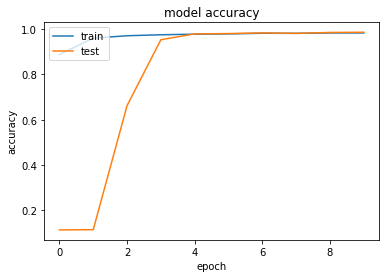

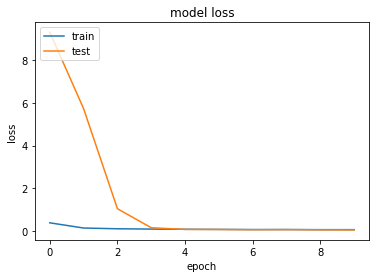

In [54]:
import matplotlib.pyplot as plt

axes = plt.gca()
#axes.set_xlim([1,5])
#axes.set_ylim([0.2,1.0])

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Train single model some more

Select a single model, train for a few epochs, and check accuracy.

In [59]:
# which model to train
i = 8

In [60]:
# reload weights in case of overfitting
models[i].load_weights("weights/model_0.26.pkl")

In [77]:
models[i].optimizer.lr = 0.0001
history = models[i].fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=1,
                   validation_data=test_batches, validation_steps=validation_steps)

Epoch 1/1
118/118 [==============================] - 11s - loss: 0.0176 - acc: 0.9944 - val_loss: 0.0215 - val_acc: 0.9932


In [120]:
# calculate accuracy of a single model
pred = np.array(models[i].predict(x_test, batch_size=eval_batch_size))
print(i, (1 - keras.metrics.categorical_accuracy(y_test, pred).eval().mean()) * 100)

8 0.260001420975


In [ ]:
models[i].save_weights("weights/weights_leaky_relu_model_0.2x"+str(i)+'.pkl')

# Try evaluation only with best performing models
Ensemble with models 0,4,5,7,8,9 gives a test error rate of 0.21%. State of the art.

In [31]:
best_model_numbers = [0,4,5,7,8,9]

In [32]:
best_models = []

for i in best_model_numbers:
    best_models.append(models[i])

In [33]:
# evaluate every model
evals = np.array([m.evaluate(x_test,y_test, batch_size=eval_batch_size) for m in best_models])

 9728/10000 [============================>.] - ETA: 0s

In [34]:
# calculate mean from evaluations
evals.mean(axis=0)

array([ 0.01087301,  0.99651667])

In [35]:
all_preds = np.stack([m.predict(x_test, batch_size=eval_batch_size) for m in best_models])

In [36]:
all_preds.shape

(6, 10000, 10)

In [37]:
avg_preds = all_preds.mean(axis=0)
avg_preds.shape

(10000, 10)

In [38]:
# display error rate in percent
(1 - keras.metrics.categorical_accuracy(y_test, avg_preds).eval().mean()) * 100

0.20999908447265625

# Visualize model

In [23]:
models[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 26, 26)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 26, 26)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 24, 24)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 24, 24)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 12, 12)        0         
__________

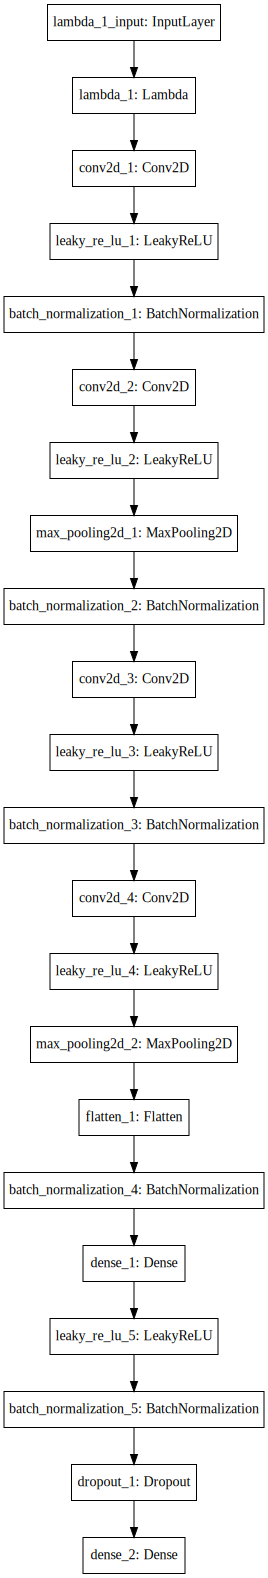

In [24]:
# fix for python3
import pydotplus as pydot

from keras.utils import plot_model
plot_model(models[0], to_file='model.png')

# visualize our model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(models[0]).create(prog='dot', format='svg'))

# Visualize predictions for ensemble
As well as looking at the overall metrics, it's also a good idea to look at examples of:
1. A few correct labels at random
2. A few incorrect labels at random

In [39]:
# decode a one hot encoded string
def one_hot_decode(encoded_seq):
    return [np.argmax(vector) for vector in encoded_seq]

In [41]:
avg_preds.shape

(10000, 10)

In [42]:
preds = np.array(one_hot_decode(avg_preds))
preds.shape

(10000,)

In [43]:
correct = np.where(preds==test_labels)[0]
incorrect = np.where(preds!=test_labels)[0]

In [44]:
correct.shape

(9979,)

In [45]:
incorrect.shape

(21,)

In [46]:
# number of images to view
n_view = 30

In [47]:
from numpy.random import permutation

# get a random selection of correctly predicted images
idx = permutation(correct)[:n_view]
idx_incorrect = permutation(incorrect)[:n_view]

In [48]:
preds_correct = preds[idx]
preds_incorrect = preds[idx_incorrect]

In [49]:
imgs = x_test[idx]
imgs_incorrect = x_test[idx_incorrect]

In [50]:
imgs.shape

(30, 1, 28, 28)

### A few correct labels at random

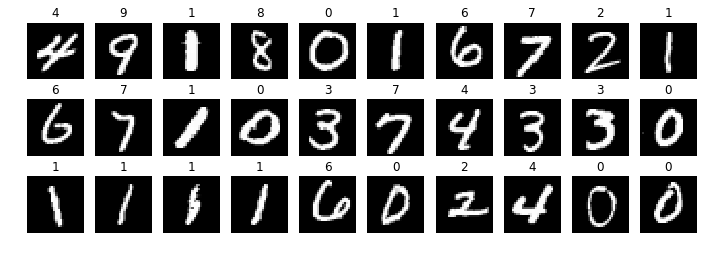

In [56]:
f = plt.figure(figsize=(12,4))

for i in range(n_view):
    sp = f.add_subplot(3, 10, i+1)
    sp.axis('Off')
    sp.set_title(preds_correct[i])
    img = imgs[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [57]:
# ground truth labels
test_labels[idx]

array([4, 9, 1, 8, 0, 1, 6, 7, 2, 1, 6, 7, 1, 0, 3, 7, 4, 3, 3, 0, 1, 1, 1,
       1, 6, 0, 2, 4, 0, 0], dtype=uint8)

### All incorrect labels

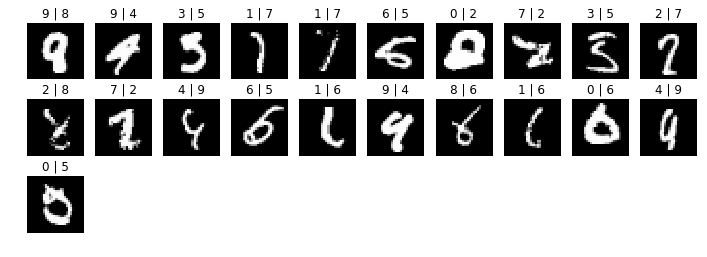

In [58]:
f = plt.figure(figsize=(12,4))

for i in range(21): # we have only 21 incorrect predictions on the test data set
    sp = f.add_subplot(3, 10, i+1)
    sp.axis('Off')
    sp.set_title("{} | {}".format(preds_incorrect[i],test_labels[idx_incorrect][i]))
    img = imgs_incorrect[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [59]:
# ground truth labels
test_labels[idx_incorrect]

array([8, 4, 5, 7, 7, 5, 2, 2, 5, 7, 8, 2, 9, 5, 6, 4, 6, 6, 6, 9, 5], dtype=uint8)

# Print confusion matrix

Plot unnormalized and normalized confusion matrices. Code adapted from 
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


In [60]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [61]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_labels, preds)

Confusion matrix, without normalization
[[ 980    0    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   1    0 1029    0    0    0    0    2    0    0]
 [   0    0    0 1010    0    0    0    0    0    0]
 [   0    0    0    0  980    0    0    0    0    2]
 [   1    0    0    2    0  887    2    0    0    0]
 [   1    2    0    0    0    0  954    0    1    0]
 [   0    2    1    0    0    0    0 1025    0    0]
 [   0    0    1    0    0    0    0    0  972    1]
 [   0    0    0    0    2    0    0    0    0 1007]]
Normalized confusion matrix
[[  1.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00
    0.00e+00   0.00e+00   0.00e+00   0.00e+00]
 [  0.00e+00   1.00e+00   0.00e+00   0.00e+00   0.00e+00   0.00e+00
    0.00e+00   0.00e+00   0.00e+00   0.00e+00]
 [  9.69e-04   0.00e+00   9.97e-01   0.00e+00   0.00e+00   0.00e+00
    0.00e+00   1.94e-03   0.00e+00   0.00e+00]
 [  0.00e+00   0.00e+00   0.00e+00   1.00e+00   0.00e+00

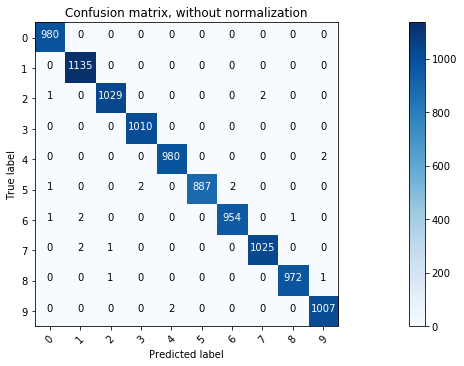

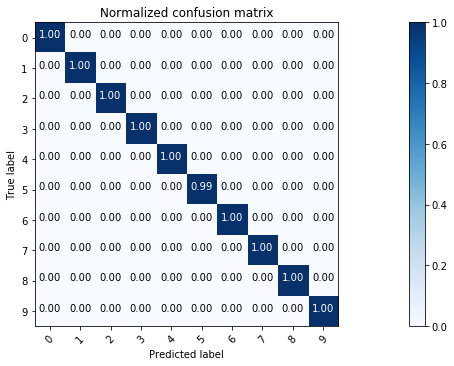

In [62]:
import itertools

class_names = [i for i in range(10)]
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,5))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(20,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Save weights if model is accurate enough

In [100]:
# save the weights for every classifier
for i, m in enumerate(models):
    m.save_weights("weights/weights_leaky_relu_model_0.22_additional_epochs"+str(i)+'.pkl')